# Community Detection

<hr style="border:2px solid black"> </hr>

## Notebook 02.03 - Perform Louvain's algorithm on network, uniformly random sampling 90% nodes

Create a recipe graph with weighted edges based on users. Analyze the graph to detect user communities, and use the distance between communities to calculate similarity scoring.

**Note** - this was run on AWS cloud, so filepaths are not relative to the repository folder and some references may need to be updated.


---

### Import libraries

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import networkx as nx
import networkx.algorithms.community as nx_comm
import sys
from sagemaker import get_execution_role
import boto3

In [6]:
def num_uniques(ser):
    try:
        return len(ser.unique())
    except:
        return "Not unique check-able"

In [7]:
def summarize_df(df):
    print("======DATA SUMMARY======")
    print("{} rows by {} columns".format(df.shape[0], df.shape[1]))
    print("\n======COLUMNS======")
    print(df.dtypes)
    print("\n======PREVIEW======")
    display(df.head())
    print("\n======NUMERICAL COL SUMMARY======")
    print(df.describe())
    print("\n")
    for col in df.columns:
        print("{}: {} unique values".format(col, num_uniques(df[col])))

---
### Create network and analyze communities

In [8]:
def determine_communities(shared_users):
    # Creating graph
    print("Creating graph variable in networkx...")
    print(time.asctime(time.localtime(time.time())))
    G = nx.from_pandas_edgelist(df=shared_users, source='recipe_id', target='recipe_id_2', edge_attr='pct_users')
    
    # Checking to see how many disconnected subgraphs were created by sampling method
    print("\nAnalyzing disconnected subgraphs...")
    print(time.asctime(time.localtime(time.time())))
    comps = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    print("There are {} disconnected subgraphs in G".format(len(comps)))
    print(comps)
    
    # Community analysis using Louvain's algorithm
    print("\nDetecting communities...")
    print(time.asctime(time.localtime(time.time())))
    louvain_communities = nx_comm.louvain_communities(G, weight='pct_users')
    print("There are {} communities".format(len(louvain_communities)))
    
    return G, louvain_communities

In [9]:
def analyze_communities(G, louvain_communities):
    # Evaluate partitions modularity
    print("Evaluating modularity..")
    l_mod = nx_comm.modularity(G, louvain_communities, weight='pct_users')
    print("Louvain modularity is {}".format(l_mod))
    
    # Evaluate partitions coverage and performance
    print("\nEvaluating coverage and performance..")
    l_coverage, l_perform = nx_comm.quality.partition_quality(G, louvain_communities)
    print("Louvain coverage is {:.3f} and performance is {:.3f}".format(l_coverage, l_perform))
    
    # Create assignments dataframe
    print("\nDetermining assignments dataframe...")
    louvain_assignments = pd.DataFrame([[node, ind] for ind, node_set in enumerate(louvain_communities) for node in node_set],
                                   columns=['recipe_id', 'community_id'])
    
    # Determine community sizes
    print("\nDetermining sizes of communities...")
    community_sizes = np.array([[i, len(a)] for i, a in enumerate(louvain_communities)])
    community_sizes = pd.DataFrame(community_sizes[community_sizes[:, 1].argsort()[::-1]], columns=['community_id', 'size'])
    print("Top 5 community sizes")
    print(community_sizes[:5])
    
    return l_mod, l_coverage, l_perform, louvain_assignments, community_sizes

In [10]:
def determine_intercommunity_distance(shared_users, louvain_communities, louvain_assignments):
    # Join clusters to shared users
    print("Joining clusters to user-level file...")
    print(time.asctime(time.localtime(time.time())))
    shared_users = shared_users.merge(louvain_assignments, on='recipe_id')
    shared_users = shared_users.merge(louvain_assignments, left_on='recipe_id_2', right_on='recipe_id', suffixes=('', '_r')) \
                            .drop('recipe_id_r', axis=1) \
                            .rename({'community_id_r':'community_id_2'}, axis=1)
    
    # Calculate the median distance between clusters
    print("\nCalculating median distance between clusters...")
    print(time.asctime(time.localtime(time.time())))
    comms = shared_users[['community_id', 'community_id_2', 'pct_users']] \
                    .groupby(by=['community_id', 'community_id_2']) \
                    .agg({'pct_users': ['median']}) \
                    .reset_index()
    comms = comms[comms['community_id'] <= comms['community_id_2']]
    comms.columns = comms.columns.map('_'.join)
    comms = comms.rename({'community_id_': 'community_id', 'community_id_2_': 'community_id_2'}, axis=1)
    
    # Invert weights for distance calculation
    print("\nInverting weights for distance calculation...")
    print(time.asctime(time.localtime(time.time())))
    comms['pct_users_median_inv'] = comms['pct_users_median'].max() - comms['pct_users_median'] \
                                + comms['pct_users_median'].min()
    
    
    # Create community graph and check subgraphs
    print("\nCreating community graph and checking subgraphs...")
    print(time.asctime(time.localtime(time.time())))
    comm_G = nx.from_pandas_edgelist(df=comms, source='community_id', target='community_id_2',
                                     edge_attr=['pct_users_median', 'pct_users_median_inv'])
    comm_comps = [len(c) for c in sorted(nx.connected_components(comm_G), key=len, reverse=True)]
    print("There are {} disconnected subgraphs in the community graph".format(len(comm_comps)))
    print(comm_comps)
        
        
    # Visualize graph
    # TBD
    
    # Use dijkstra's algorithm to calculate all to all distances
    print("\nCalculating distances...")
    print(time.asctime(time.localtime(time.time())))
    comm_dists = dict(nx.all_pairs_dijkstra_path_length(comm_G, weight='pct_users_median_inv'))
    comm_dists = pd.DataFrame([[source, dest, dist] for source, dists in comm_dists.items() for dest, dist in dists.items()], 
                                 columns=['community_id', 'community_id_2', 'community_distance'])
    comm_dists = comm_dists[comm_dists['community_id'] != comm_dists['community_id_2'] ]
    print("Complete")
    
    return comms, comm_dists, comm_comps
    

In [11]:
# Import data
role = get_execution_role()
bucket='sagemaker-cse-6242'
data_key = 'clustering_data_filtered_pctthresh-08'
data_location = 's3://{}/{}'.format(bucket, data_key)
shared_users = pd.read_parquet(data_location)

In [12]:
# Sample data
shared_nodes = pd.concat([shared_users['recipe_id'], shared_users['recipe_id']]).unique()
sampled_nodes = np.random.choice(shared_nodes, size=int(.9*len(shared_nodes)), replace=False)
sampled_users = shared_users[(shared_users['recipe_id'].isin(sampled_nodes)) & (shared_users['recipe_id_2'].isin(sampled_nodes))]
summarize_df(sampled_users)

======DATA SUMMARY======
42453929 rows by 3 columns

======COLUMNS======
recipe_id        int64
recipe_id_2      int64
pct_users      float64
dtype: object

======PREVIEW======


,recipe_id,recipe_id_2,pct_users
0,0,1118,0.166667
1,60,1118,0.125000
2,1066,1118,0.166667
3,1086,1118,0.100000
159,0,11190,0.125000



======NUMERICAL COL SUMMARY======
          recipe_id   recipe_id_2     pct_users
count  4.245393e+07  4.245393e+07  4.245393e+07
mean   5.986392e+04  1.190816e+05  1.520578e-01
std    4.194603e+04  4.181577e+04  6.699510e-02
min    0.000000e+00  3.700000e+01  8.000000e-02
25%    2.440700e+04  8.970000e+04  1.000000e-01
50%    5.237900e+04  1.264010e+05  1.250000e-01
75%    8.970400e+04  1.544320e+05  2.000000e-01
max    1.782240e+05  1.782560e+05  6.666667e-01


recipe_id: 74038 unique values
recipe_id_2: 73235 unique values
pct_users: 331 unique values


In [13]:
# Assign communities
G, l_communities = determine_communities(sampled_users)

Creating graph variable in networkx...
Mon Apr 11 18:45:32 2022

Analyzing disconnected subgraphs...
Mon Apr 11 18:47:32 2022
There are 1 disconnected subgraphs in G
[74190]

Detecting communities...
Mon Apr 11 18:47:44 2022
There are 17 communities


In [14]:
# Evaluate communities
l_mod, l_coverage, l_perform, l_assign, comm_sizes = analyze_communities(G, l_communities)

Evaluating modularity..
Louvain modularity is 0.47454791046563877

Evaluating coverage and performance..
Louvain coverage is 0.528 and performance is 0.798

Determining assignments dataframe...

Determining sizes of communities...
Top 5 community sizes
   community_id   size
0             0  30030
1             4  11095
2            16   4813
3             7   3918
4            13   3542


In [15]:
comm_sizes.describe()

,community_id,size
count,17.000000,17.000000
mean,8.000000,4364.117647
std,5.049752,7051.409787
min,0.000000,28.000000
25%,4.000000,1658.000000
50%,8.000000,2093.000000
75%,12.000000,3542.000000
max,16.000000,30030.000000


In [16]:
# Determine intercommunity distances
comms, c_dists, c_comps = determine_intercommunity_distance(shared_users, l_communities, l_assign)

Joining clusters to user-level file...
Mon Apr 11 19:02:26 2022

Calculating median distance between clusters...
Mon Apr 11 19:02:40 2022

Inverting weights for distance calculation...
Mon Apr 11 19:02:42 2022

Creating community graph and checking subgraphs...
Mon Apr 11 19:02:42 2022
There are 1 disconnected subgraphs in the community graph
[17]

Calculating distances...
Mon Apr 11 19:02:42 2022
Complete


In [17]:
def visualize_community_graph(comms, node_sizes, k=0.4, alpha=0.9):
    edge_list = [(r[0],r[1]) for r in np.array(comms[comms['community_id'] != comms['community_id_2']][['community_id', 'community_id_2']])]
    G = nx.from_pandas_edgelist(df=comms, source='community_id', target='community_id_2', 
                                edge_attr=['pct_users_median'])
    node_sizes = node_sizes[node_sizes['community_id'].apply(lambda x: x in list(G.nodes()))]
    node_list = node_sizes['community_id']
    node_sizes = node_sizes['size']/20
#     weights = list(nx.get_edge_attributes(G,'pct_users_median').values())
#     widths = [int((a - min(weights[:-1]))/(max(weights[:-1]) - min(weights[:-1]))*4) for a in weights]
#     print(widths)
    plt.figure(figsize=(5, 4))
    nx.draw(G, nodelist=node_list, node_size=node_sizes, edgelist=edge_list, width=0.2,
            alpha=alpha, pos=nx.spring_layout(G, weight='pct_users_median', k=k))

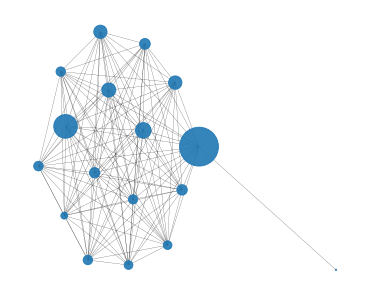

In [18]:
visualize_community_graph(comms, comm_sizes, k=0.9)

---
### Check all recipes are in the assignments

In [19]:
# Import data
role = get_execution_role()
bucket='sagemaker-cse-6242'
data_key = 'users_in_count2_mean4.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
u_recipes = pd.read_csv(data_location)['recipe_id'].unique()

In [20]:
# Import data
role = get_execution_role()
bucket='sagemaker-cse-6242'
data_key = 'recipes_in_count2_mean4.parquet'
data_location = 's3://{}/{}'.format(bucket, data_key)
r_recipes = pd.read_parquet(data_location).reset_index()['recipe_id'].unique()

In [22]:
assign_recipes = l_assign['recipe_id'].unique()

In [23]:
def check_recipes(list_og, list_check):
    missing = []
    for r in list_og:
        if r not in list_check:
            missing += [r]
    
    print("{} of {} recipes missing".format(len(missing), len(list_og)))
    return missing

In [24]:
u_recipes_missing = check_recipes(u_recipes, assign_recipes)

11329 of 85519 recipes missing


In [25]:
r_recipes_missing = check_recipes(r_recipes, assign_recipes)

6396 of 48454 recipes missing


---
### Check all distances are accounted for

In [26]:
def check_distance(louvain_communities, comm_dist):
    expected = len(louvain_communities)**2 - len(louvain_communities)
    got = comm_dist.shape[0]
    print("Expected {} distance records, got {}".format(expected, got))

In [27]:
check_distance(l_communities, c_dists)

Expected 272 distance records, got 272


In [29]:
# Write out files
# Community assignments
data_key = 'community_assignments_sample-90.parquet'
l_assign.to_parquet(data_key)

# Community distances
data_key = 'community_distances_sample-90.parquet'
c_dists.to_parquet(data_key)

# Community graph edges
data_key = 'community_graph_edges_sample-90.parquet'
comms.to_parquet(data_key)

# Community graph subgraphs
data_key = 'community_graph_subg_sample-90.parquet'
np.savetxt(data_key, np.array(c_comps))